<a href="https://colab.research.google.com/github/AmritSDutta/colab_ml/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [3]:
device = 'cuda' if torch.accelerator.is_available() else 'cpu'


In [4]:
class EncoderV1(nn.Module):
    def __init__(self, latent_dim):
        super(EncoderV1, self).__init__()
        self.first = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.second = nn.Sequential(
            nn.Linear(256, 392),
            nn.ReLU(),
            nn.Linear(392, latent_dim)
        )

    def forward(self, x):
            x= self.first(x)
            x= F.relu(x)
            x = x.reshape((-1, 256))
            x = self.second(x)

            return x

In [5]:
encoded = EncoderV1(2)(torch.randn(1,1,28,28))

In [6]:
class DecoderV1(nn.Module):
    def __init__(self, latent_dim):
        super(DecoderV1, self).__init__()
        self.first = nn.Sequential(
            nn.Linear(latent_dim, 392),
            nn.ReLU(),
            nn.Linear(392, 784)
        )

    def forward(self, x):
        x= self.first(x)
        decoded = F.relu(x)
        return decoded.reshape((-1, 1, 28, 28))


In [7]:
DecoderV1(2)(encoded)

tensor([[[[0.0000e+00, 1.2645e-02, 7.5045e-02, 0.0000e+00, 2.7924e-02,
           2.7627e-04, 1.3886e-01, 0.0000e+00, 0.0000e+00, 1.7027e-01,
           0.0000e+00, 4.2776e-02, 8.7019e-02, 3.1637e-02, 1.3501e-01,
           9.8229e-02, 0.0000e+00, 0.0000e+00, 3.3135e-01, 1.6984e-01,
           1.0384e-01, 0.0000e+00, 4.2793e-01, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [2.5879e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 4.0258e-02, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 1.5084e-01, 0.0000e+00, 1.2192e-01, 4.4150e-02,
           2.0527e-01, 0.0000e+00, 9.2935e-02, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           8.2626e-02, 0.0000e+00, 0.0000e+00],
          [4.9585e-02, 7.8634e-02, 0.0000e+00, 2.9964e-01, 5.6922e-02,
           8.2932e-02, 4.1533e-02, 6.3274e-02, 4.2823e-03, 6.9019e-02,
           0.0000e+00, 3.8462e-02, 1.7757e-01, 0.000

In [8]:
class AutoEncoderV1(nn.Module):
    def __init__(self, latent_dim):
        super(AutoEncoderV1, self).__init__()
        self.encoder = EncoderV1(latent_dim)
        self.decoder = DecoderV1(latent_dim)

    def forward(self, x):
        #x = x.reshape((-1, 784))
        encoded = self.encoder(x)
        return self.decoder(encoded)


In [9]:
def train(model, data, epochs=5):
    opt = torch.optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = model(x)
            loss = loss_fn(x,x_hat)
            loss.backward()
            opt.step()
        print(f'epoch: {epoch} , loss: {loss}')
    return model

In [10]:
latent_dims = 16
autoencoder_model = AutoEncoderV1(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=32,
        shuffle=True)

autoencoder = train(autoencoder_model, data)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.90MB/s]


epoch: 0 , loss: 0.034871067851781845
epoch: 1 , loss: 0.02558894455432892
epoch: 2 , loss: 0.027675900608301163
epoch: 3 , loss: 0.02472199872136116
epoch: 4 , loss: 0.020672671496868134


In [14]:
test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=torchvision.transforms.ToTensor())

test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=32, shuffle=True)

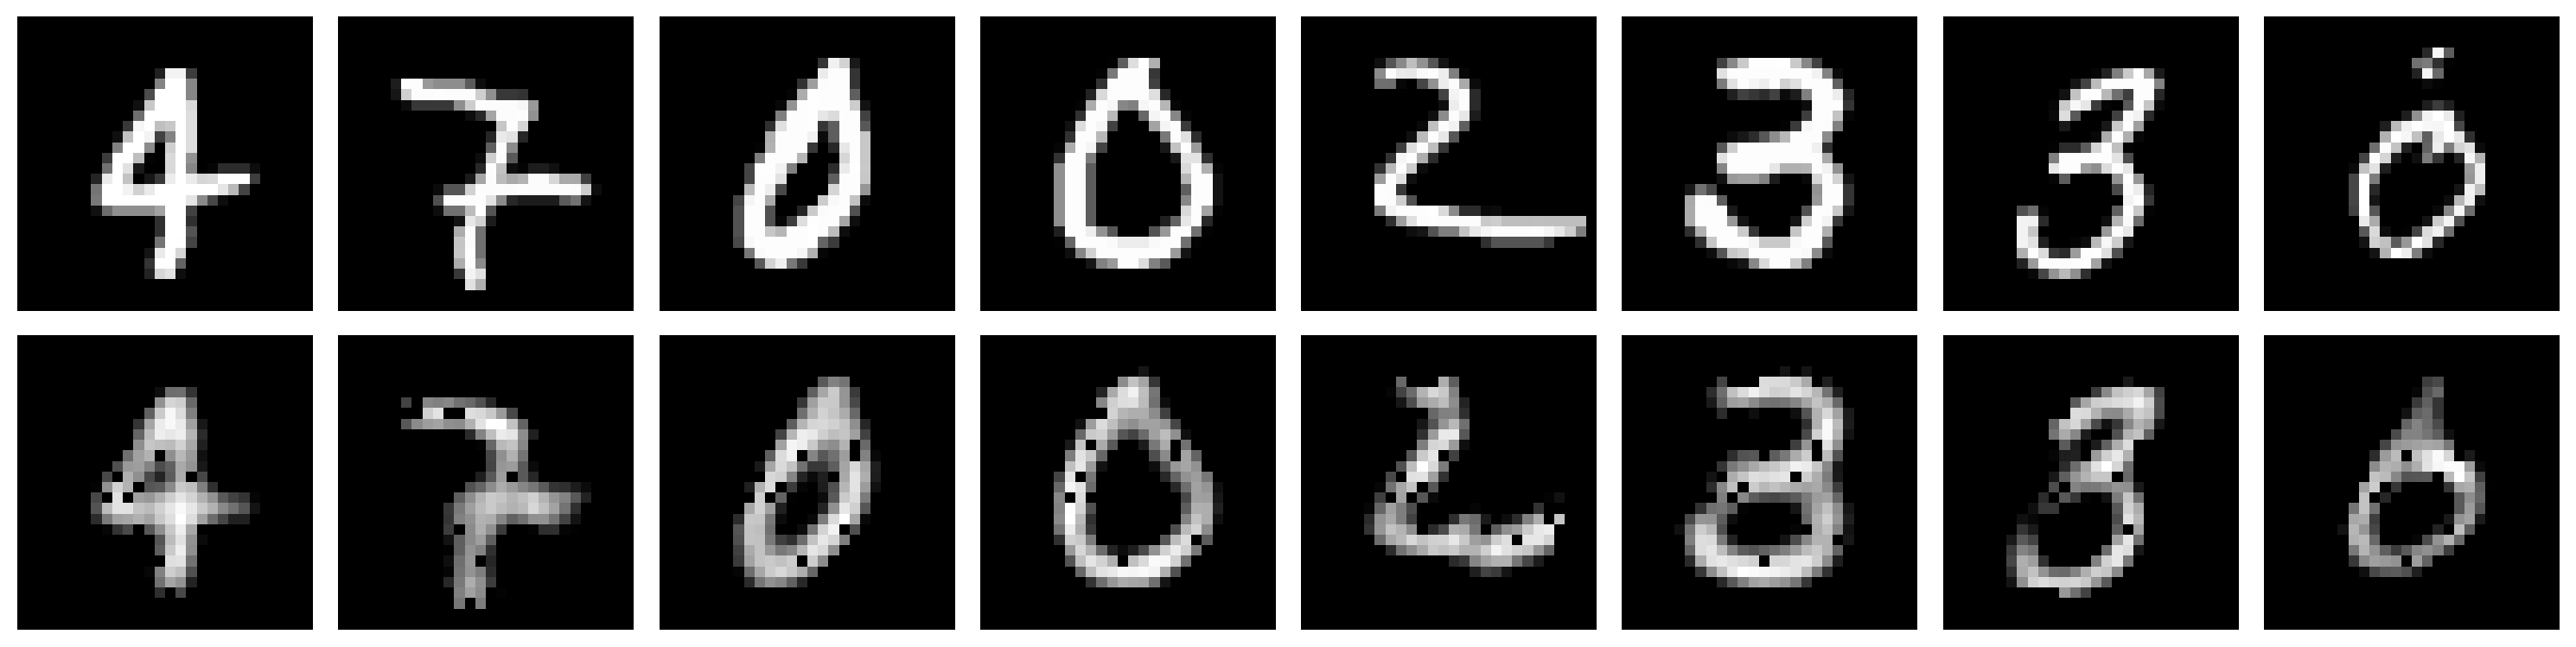

In [16]:
def visualize_rebuild(model, data_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        reconstructed = model(images)

        # Plot original vs reconstructed images
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        for i in range(8):
            # Original images
            axes[0,i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0,i].axis('off')

            # Reconstructed images
            axes[1,i].imshow(reconstructed[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1,i].axis('off')

        plt.tight_layout()
        plt.show()

# Visualize results
visualize_rebuild(autoencoder, test_dataloader)